<a href="https://colab.research.google.com/github/lenafranklin/satgan/blob/main/satgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install ipython
!mkdir data
!cd data
!mkdir data/Residential
!mkdir data/Highways
!mkdir data/AnnualCrop
!mkdir data/Residential/Residential
!mkdir data/Highways/Highways
!mkdir data/AnnualCrop/AnnualCrop
!mkdir results

Stuff to look at
- look at scale within individual images and use this to mess with kernel size (especially in the early layers)
- make sure some of the features still make it through to middle layers
- try training on a ton more epochs

RESOURCES USED

The Paper https://papers.nips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf

https://github.com/soumith/ganhacks

https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e

Pytorch Documentation https://pytorch.org/docs/stable/index.html 

https://machinelearningmastery.com/how-to-evaluate-generative-adversarial-networks/

Pros and Cons of GAN Evaluation Measures https://arxiv.org/abs/1802.03446


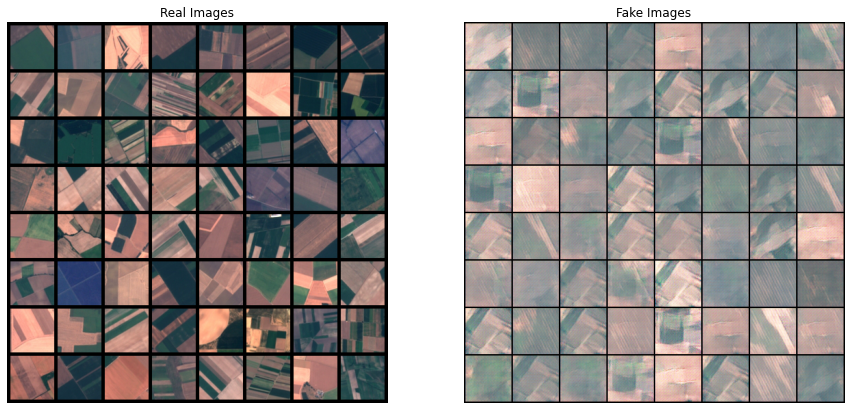

In [ ]:
from __future__ import print_function
#%matplotlib inline
import torch
import torchvision
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

num_epochs= 1000
image_type= "AnnualCrop"
dfile= "./results/"+image_type+"D_"+str(num_epochs)+"epochs"
gfile= "./results/"+image_type+"G_"+str(num_epochs)+"epochs"
dataroot= './data/'+image_type
ngpu= 1

device= torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# load the nets
netG= Generator(ngpu).to(device)
netG.load_state_dict(torch.load(gfile))
netG.eval()

netD= Discriminator(ngpu).to(device)
netD.load_state_dict(torch.load(dfile))
netD.eval()

data_path = dataroot
dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=torchvision.transforms.ToTensor()
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True
)

img_list = []
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

# real images from the dataloader
real_batch = next(iter(dataloader))
# plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

plt.savefig("results/"+image_type+"_"+str(num_epochs)+"epochs.png")
plt.show()


[0/1000]	Loss_D: 1.4677	Loss_G: 2.9736	D(x): 0.4000	D(G(z)): 0.2728 / 0.0626
[1/1000]	Loss_D: 0.0064	Loss_G: 18.8011	D(x): 0.9936	D(G(z)): 0.0000 / 0.0000
[2/1000]	Loss_D: 0.0167	Loss_G: 14.4548	D(x): 0.9849	D(G(z)): 0.0000 / 0.0000
[3/1000]	Loss_D: 0.1002	Loss_G: 4.6241	D(x): 0.9382	D(G(z)): 0.0313 / 0.0110
[4/1000]	Loss_D: 0.1743	Loss_G: 4.4430	D(x): 0.9142	D(G(z)): 0.0141 / 0.0217
[5/1000]	Loss_D: 1.7671	Loss_G: 12.9735	D(x): 0.9456	D(G(z)): 0.8002 / 0.0000
[6/1000]	Loss_D: 0.7584	Loss_G: 3.0580	D(x): 0.7175	D(G(z)): 0.3198 / 0.0581
[7/1000]	Loss_D: 0.7167	Loss_G: 2.2886	D(x): 0.6682	D(G(z)): 0.2328 / 0.1275
[8/1000]	Loss_D: 0.9145	Loss_G: 3.4802	D(x): 0.9164	D(G(z)): 0.5502 / 0.0350
[9/1000]	Loss_D: 1.8348	Loss_G: 0.6028	D(x): 0.1938	D(G(z)): 0.0166 / 0.5627
[10/1000]	Loss_D: 0.8849	Loss_G: 2.5366	D(x): 0.6623	D(G(z)): 0.3526 / 0.0936
[11/1000]	Loss_D: 0.4581	Loss_G: 3.1290	D(x): 0.6935	D(G(z)): 0.0543 / 0.0588
[12/1000]	Loss_D: 0.4364	Loss_G: 5.0455	D(x): 0.8274	D(G(z)): 0.1676 / 

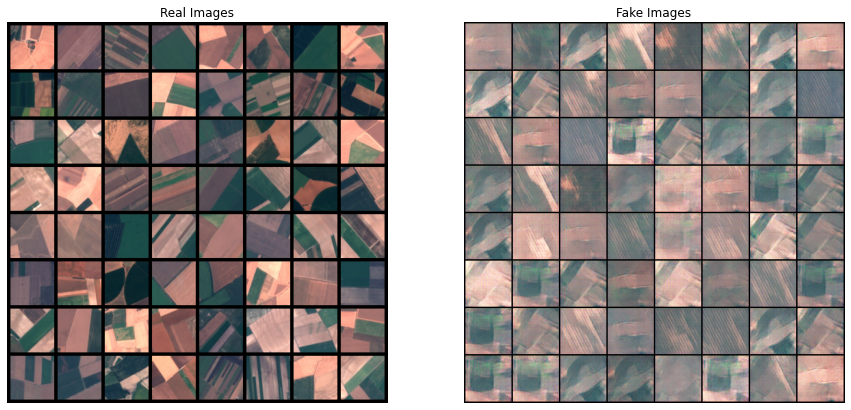

In [ ]:
#ACTUAL MODEL CODE

from __future__ import print_function
#%matplotlib inline
import torch
import torchvision
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML



# GAN model created closely following DCGAN Tutorial on pytorch

"""
SET VARIOUS THINGS
"""
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
dataroot= './data/AnnualCrop' # folder with data
outpath= './results/'
outprefix= 'AnnualCrop'
workers= 0
batch_size= 64
image_size= 64
nc= 3 # 3 color channels - RGB
nz= 100 # size of generator input
ngf= 64 # size of feature maps in generator
ndf= 64 # size of feature maps in discriminator
num_epochs= 1000
lr= 0.0002 # why not (MESS WITH THIS LATER)
beta1= 0.5 # what does this do? who knows. something for the Adam optim
ngpu= 1 # number of GPUs

# choose device to use (gpu or cpu)
device= torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

"""
LOAD THE DATA
"""

#TODO: maybe add functionality for specifying which dataset to
# look at ie. residential, annual crops, etc. ?
data_path = dataroot
dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=torchvision.transforms.ToTensor()
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True
)

# oh look a function i definitely didn't write myself thanks pytorch
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
"""
make the generator 
dcgan ~ so use both convolutional and convolutional transpose layers
transpose layer ~ "reverses" convolution (but only in terms of dimensions)
fun transpose layer explanation/animation https://github.com/aqeelanwar/conv_layers_animation 
basically it does this for upsampling purposes, which is useful for generative models
but how it mathematically works I have no idea
"""

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.model = nn.Sequential(
            # want to create RGB image w/ same size as truth images
            # nz ~ length of the z input vector, which will be mapped to "data space"
            # ngf ~ generator feature maps
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # (ngf) x 32 x 32
            # we want nc output channels (in this case 3 for RGB)
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            # this is the activation function
            # TODO: do more research on tanh as an activation function and
            # figure out if there is anything better suited
            # Goodfellow et al. uses sigmoid here BUT "ganhacks" github suggests
            # using Tanh() instead
            nn.Tanh()
            # (nc) x 64 x 64 - now this is an appropriate size to go in discriminator

        )

    def forward(self, input):
        return self.model(input)

# make a generator and initialize appropriately w weights
netG= Generator(ngpu).to(device)
netG.apply(weights_init)

# basically the generator but backwards
# TODO: used leaky relu here but try relu and see what happens
# can't really see a huge downside in using leaky here tho
# Goodwell et al also use dropout in training the discriminator
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.model = nn.Sequential(
            # Goodwell et al use maxout activations THROUGHOUT
            # But many examples online use Leaky RELU - noted as a good option
            # by ganhacks
            # TODO: investigate/experiment with different activations
            # (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)
        
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

# BCELoss function to train with tho it's not really a helpful 
# metric for bigger picture evaluation of how everything is doing
criterion = nn.BCELoss()

# latent vectors for the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# real and fake labels to use during training
real_label = 1.
fake_label = 0.

# optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# for tracking progress 
img_list = []
G_losses = []
D_losses = []
iters = 0

"""
x ~ an image
D(x) ~ discriminator, outputs a scalar, the probability that x came from "real" 
    training data as opposed
    to the discriminator. Will be high for "real" x from training data, low from 
    fake generated x, this is like a binary classifier
G(z) ~ generator, maps some random latent vector z to "data space" (an image)
D(G(z)) ~ the probability that an output of generator G is a real images
"""

# TRAINING
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # this part is for the discriminator
        # first we train with a batch comprised of only real images
        # want to maximize log(D(x)) + log(1 - D(G(z)))
        
        netD.zero_grad()
        # formatting
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        # find and propagate loss
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # now train with some fake image batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # generate fake images
        fake = netG(noise)
        label.fill_(fake_label)
        # classify fake images
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        """
        update generator
        from ganhacks: "In GAN papers, the loss function to optimize G is 
        min (log 1-D), but in practice folks practically use max log D"
        """
        netG.zero_grad()
        label.fill_(real_label) 
        # forward pass of all-fake batch through D
        output = netD(fake).view(-1)

        # Calculate G's loss, gradients, and update
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training statistics
        # But not very often because tbh these stats are only useful for
        # making sure the program hasn't gotten stuck somewhere
        if i % 100 == 0:
            print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs,
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # tracking losses
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
        iters += 1
"""
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
"""
# save the model
torch.save(netD.state_dict(), outpath+outprefix+"D_"+str(num_epochs)+"epochs")
torch.save(netG.state_dict(), outpath+outprefix+"G_"+str(num_epochs)+"epochs")

# real images from the dataloader
real_batch = next(iter(dataloader))
# plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()
